<a href="https://colab.research.google.com/github/mahdaalma/ALMA-/blob/main/ARIMA_DATA_FULL_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA

In [1]:
!pip install PythonTsa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from PythonTsa.plot_acf_pacf import acf_pacf_fig
from scipy.stats import boxcox,  boxcox_llf
from statsmodels.stats.diagnostic import het_arch

import warnings

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 16.1 MB/s eta 0:00:00


In [49]:
#Data IHSG dan Variabel Makroekonomi
IHSG=pd.read_csv('https://raw.githubusercontent.com/mahdaalma/ALMA-/main/data_ihsg_2007_2024-2.csv', sep=',')
IHSG.head(10)

,Date,Open,High,Low,Close,AdjClose,Volume,Inflasi,Kurs Jual,Kurs Beli,Kurs Tengah
0,1/31/2007,1813.45,1843.35,1627.76,1757.26,1757.19,501642800,6.26%,9111.818182,9021.181818,9066.500000
1,2/28/2007,1765.87,1824.99,1664.20,1740.97,1740.90,482985200,6.30%,9112.850000,9022.750000,9067.800000
2,3/31/2007,1752.11,1833.42,1692.22,1830.92,1830.85,445107500,6.52%,9209.952381,9117.952381,9163.952381
3,4/30/2007,1837.18,2021.01,1837.18,1999.17,1999.09,486833700,6.29%,9142.900000,9052.200000,9097.550000
4,5/31/2007,1995.17,2111.83,1987.89,2084.32,2084.24,550720100,6.01%,8888.476190,8800.190476,8844.333333
5,6/30/2007,2100.68,2167.45,2045.58,2139.28,2139.19,517207000,5.77%,9028.550000,8938.750000,8983.650000
6,7/31/2007,2140.62,2405.96,2140.62,2348.67,2348.58,376941900,6.06%,9112.363636,9021.909091,9067.136364
7,8/31/2007,2318.70,2322.80,1863.36,2194.34,2194.25,550133600,6.51%,9413.545455,9319.818182,9366.681818
8,9/30/2007,2194.43,2385.24,2192.79,2359.21,2359.11,891354100,6.95%,9356.500000,9263.300000,9309.900000
9,10/31/2007,2366.61,2689.92,2366.61,2643.49,2643.38,876734500,6.88%,9152.705882,9061.411765,9107.058824


In [50]:
#memeriksa tipe data
IHSG.dtypes

,0
Date,object
Open,float64
High,float64
Low,float64
Close,float64
AdjClose,float64
Volume,int64
Inflasi,object
Kurs Jual,float64
Kurs Beli,float64


In [51]:
#mengubah type data menjadi datetime
IHSG['Date'] = pd.to_datetime(IHSG['Date'], format='%m/%d/%Y') # Changed the format string to '%m/%d/%Y'

In [52]:
#memeriksa tipe data
IHSG.dtypes

,0
Date,datetime64[ns]
Open,float64
High,float64
Low,float64
Close,float64
AdjClose,float64
Volume,int64
Inflasi,object
Kurs Jual,float64
Kurs Beli,float64


In [53]:
#Hapus baris yang mengandung NaN
IHSG = IHSG.dropna()


# PREPROCESSING

In [54]:
# Sortir berdasarkan tanggal dan jadikan index
IHSG = IHSG.sort_values('Date')
IHSG.set_index('Date', inplace=True)

# Pilih kolom yang dibutuhkan
data = IHSG[['Close', 'Open']].dropna()

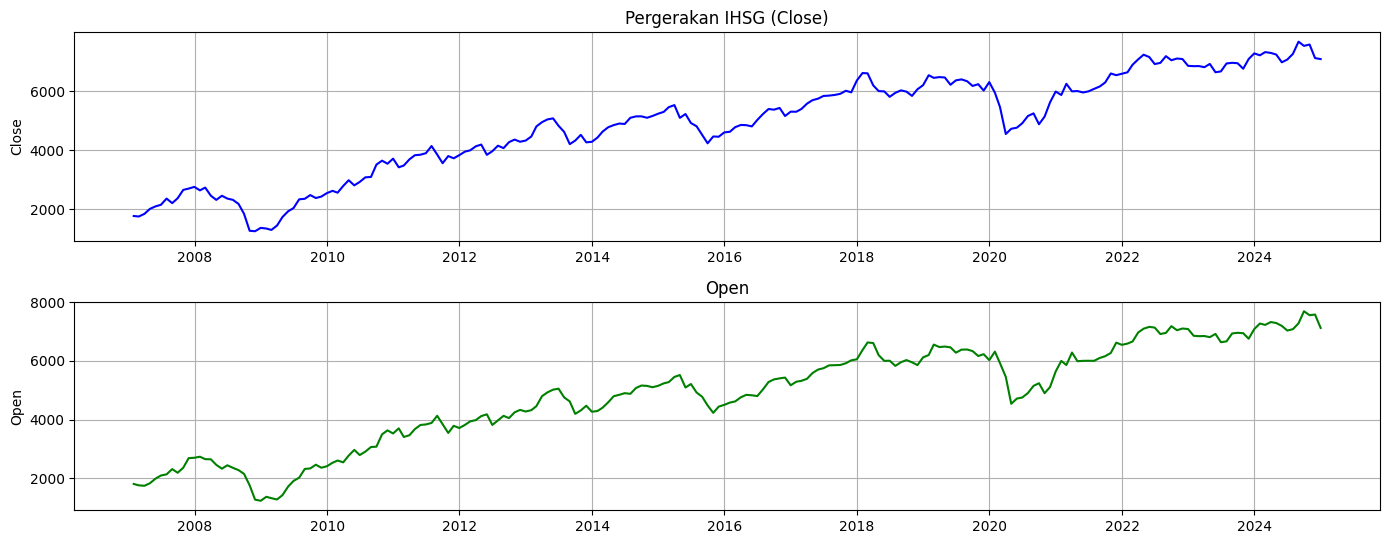

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

# Plot Close
plt.subplot(3, 1, 1)
plt.plot(data.index, data['Close'], color='blue')
plt.title('Pergerakan IHSG (Close)')
plt.ylabel('Close')
plt.grid(True)

# Plot Inflasi
plt.subplot(3, 1, 2)
plt.plot(data.index, data['Open'], color='green')
plt.title('Open')
plt.ylabel('Open')
plt.grid(True)


plt.tight_layout()
plt.show()

# SPLITING DATA TRAINING DAN TESTING

In [56]:
# Split di akhir 2022
train = data[:'2022']
test = data['2023':]

y_train = train['Close']
y_test = test['Close']
y_train_open = train['Open']
y_test_open= test['Open']

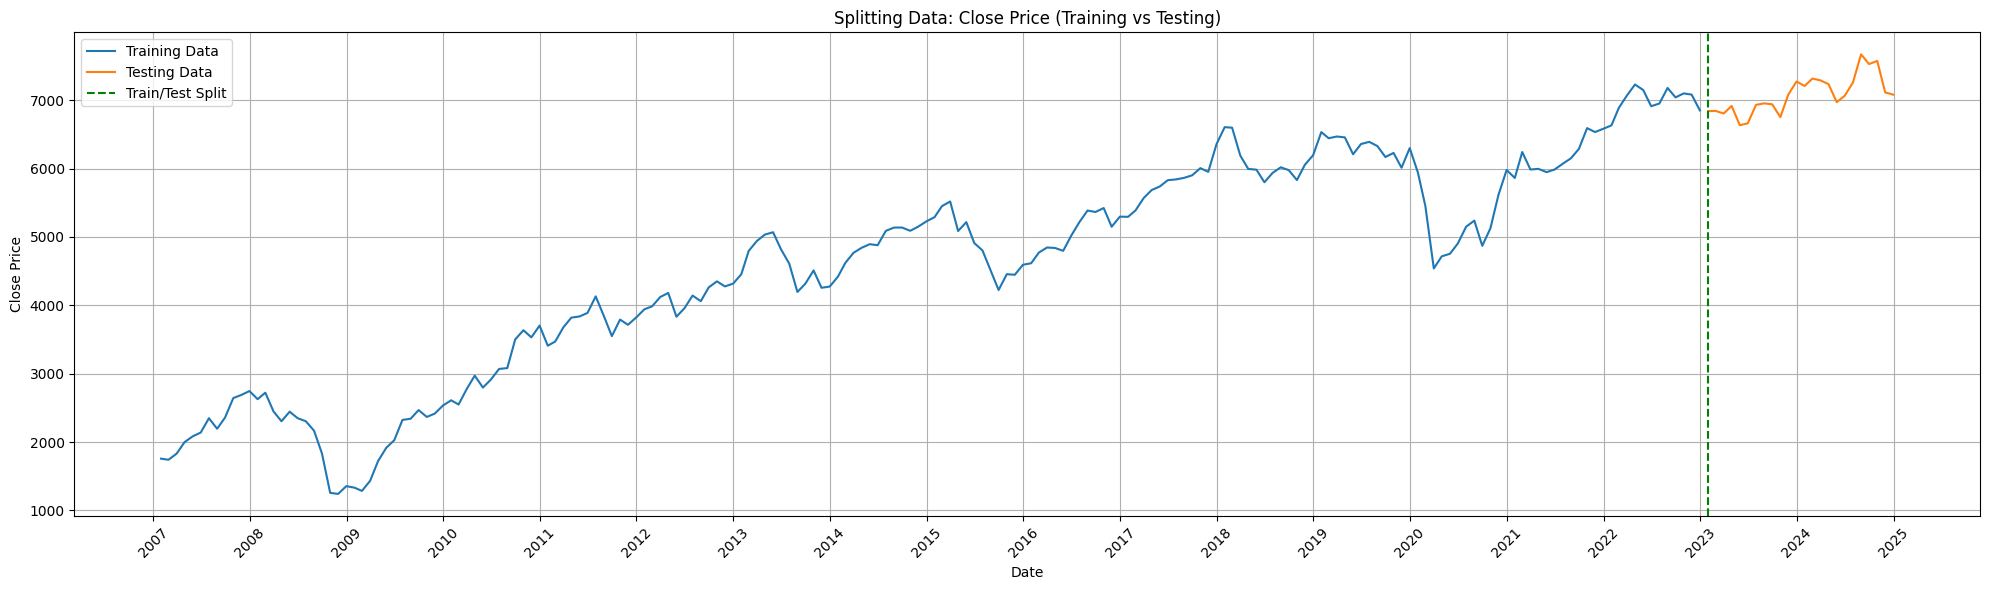

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(20, 6))
plt.plot(y_train.index, y_train, label='Training Data')
plt.plot(y_test.index, y_test, label='Testing Data')
plt.axvline(x=y_test.index[0], color='green', linestyle='--', label='Train/Test Split')

# Format sumbu x agar menampilkan semua tahun
plt.gca().xaxis.set_major_locator(mdates.YearLocator())     # Lokator tahunan
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format jadi tahun saja
plt.xticks(rotation=45)  # Rotasi label agar tidak saling tumpang tindih

plt.title('Splitting Data: Close Price (Training vs Testing)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Supaya label tidak terpotong
plt.show()

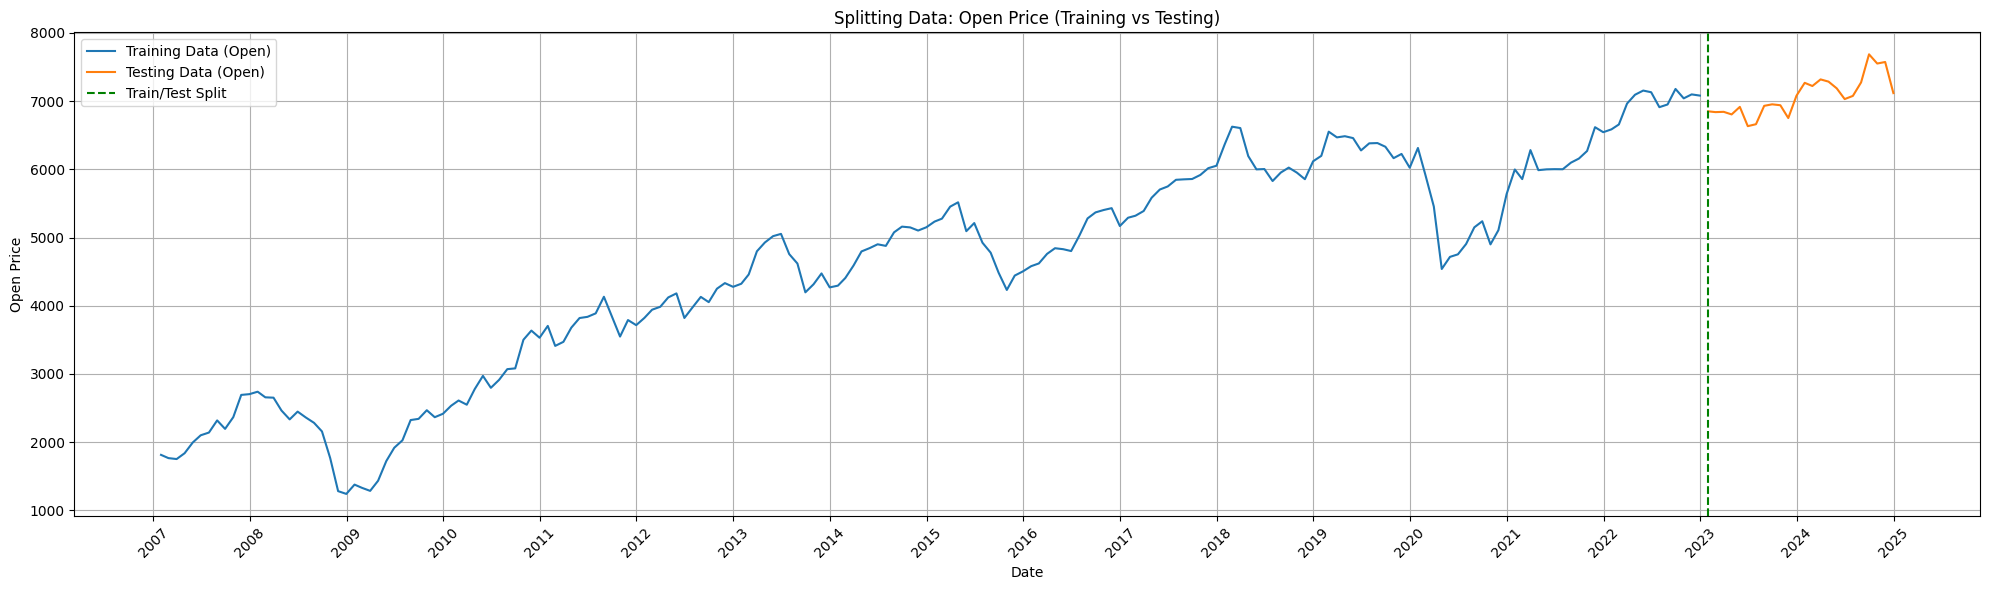

In [59]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(20, 6))
plt.plot(y_train_open.index, y_train_open, label='Training Data (Open)')
plt.plot(y_test_open.index, y_test_open, label='Testing Data (Open)')
plt.axvline(x=y_test_open.index[0], color='green', linestyle='--', label='Train/Test Split')

# Format sumbu x agar menampilkan semua tahun
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.title('Splitting Data: Open Price (Training vs Testing)')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [60]:
# Display the first 10 rows of the training data
print("Training Data (first 10 rows):")
print(train.head(12))

# Display the first 10 rows of the testing data
print("\nTesting Data (first 10 rows):")
print(test.head(12))


Training Data (first 10 rows):
              Close     Open
Date                        
2007-01-31  1757.26  1813.45
2007-02-28  1740.97  1765.87
2007-03-31  1830.92  1752.11
2007-04-30  1999.17  1837.18
2007-05-31  2084.32  1995.17
2007-06-30  2139.28  2100.68
2007-07-31  2348.67  2140.62
2007-08-31  2194.34  2318.70
2007-09-30  2359.21  2194.43
2007-10-31  2643.49  2366.61
2007-11-30  2688.33  2692.51
2007-12-31  2745.83  2703.72

Testing Data (first 10 rows):
              Close     Open
Date                        
2023-01-31  6839.34  6850.74
2023-02-28  6843.24  6838.92
2023-03-31  6805.28  6843.10
2023-04-30  6915.72  6805.28
2023-05-31  6633.26  6915.72
2023-06-30  6661.88  6633.26
2023-07-31  6931.36  6661.74
2023-08-31  6953.26  6931.08
2023-09-30  6939.89  6953.26
2023-10-31  6752.21  6939.89
2023-11-30  7080.74  6751.94
2023-12-31  7272.80  7080.06


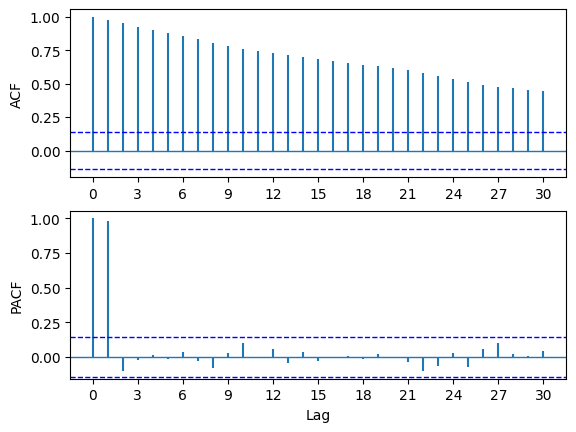

In [62]:
#Plot acf dan pacf data train close
acf_pacf_fig(y_train, both=True, lag=30); plt.show()


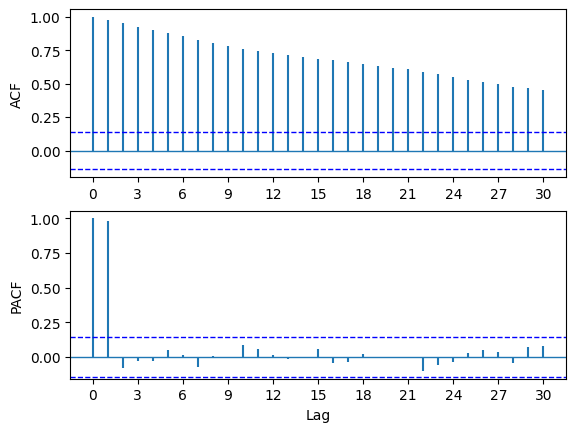

In [63]:
#Plot acf dan pacf data train open
acf_pacf_fig(y_train_open, both=True, lag=30); plt.show()

In [64]:
from statsmodels.tsa.stattools import adfuller

# === ADF untuk data Close ===
print("=== ADF Test - Data Train Close ===")
result_close = adfuller(y_train, autolag='AIC')
print("ADF Statistic:", result_close[0])
print("p-value:", result_close[1])
print("Critical Values:")
for key, value in result_close[4].items():
    print(f"   {key}: {value}")
print("Kesimpulan:", "Stasioner" if result_close[1] < 0.05 else "Tidak Stasioner")
print()

# === ADF untuk data Open ===
print("=== ADF Test - Data Train Open ===")
result_open = adfuller(y_train_open, autolag='AIC')
print("ADF Statistic:", result_open[0])
print("p-value:", result_open[1])
print("Critical Values:")
for key, value in result_open[4].items():
    print(f"   {key}: {value}")
print("Kesimpulan:", "Stasioner" if result_open[1] < 0.05 else "Tidak Stasioner")

=== ADF Test - Data Train Close ===
ADF Statistic: -1.349414306471185
p-value: 0.6062732078052089
Critical Values:
   1%: -3.4652439354133255
   5%: -2.8768752281673717
   10%: -2.574944653739612
Kesimpulan: Tidak Stasioner

=== ADF Test - Data Train Open ===
ADF Statistic: -1.1697070315215379
p-value: 0.6864893898862714
Critical Values:
   1%: -3.4652439354133255
   5%: -2.8768752281673717
   10%: -2.574944653739612
Kesimpulan: Tidak Stasioner


# STASIONERITAS

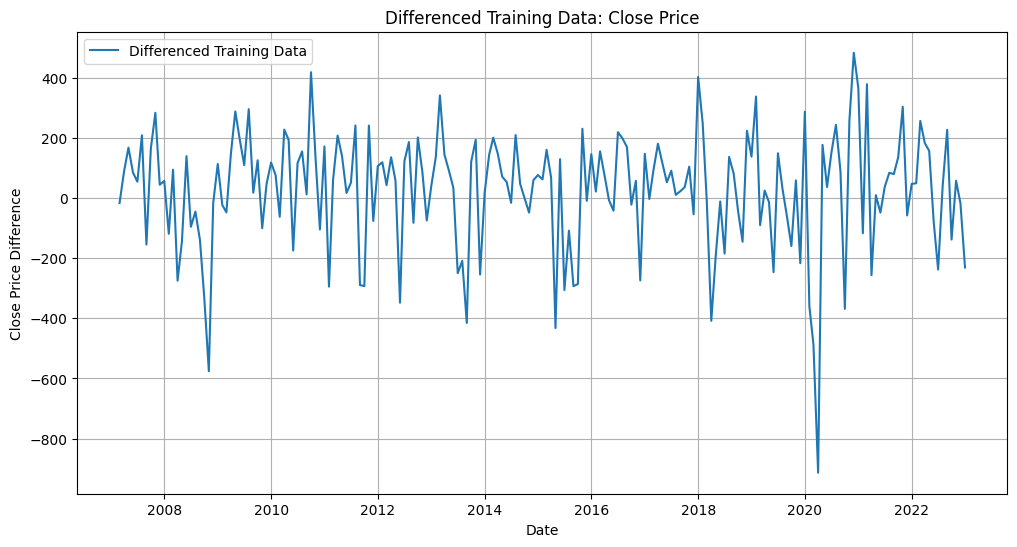

p-value (differenced data): 9.653970894328986e-22


In [17]:
# prompt: lakukan differencing data y_train

import matplotlib.pyplot as plt
# Calculate the difference of the y_train series
y_train_diff = y_train.diff().dropna()

# Plot the differenced series
plt.figure(figsize=(12, 6))
plt.plot(y_train_diff.index, y_train_diff, label='Differenced Training Data')
plt.title('Differenced Training Data: Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price Difference')
plt.legend()
plt.grid(True)
plt.show()

# Perform ADF test on the differenced data
result_diff = adfuller(y_train_diff, autolag='AIC')
p_value_diff = float(result_diff[1])
print("p-value (differenced data):", p_value_diff)


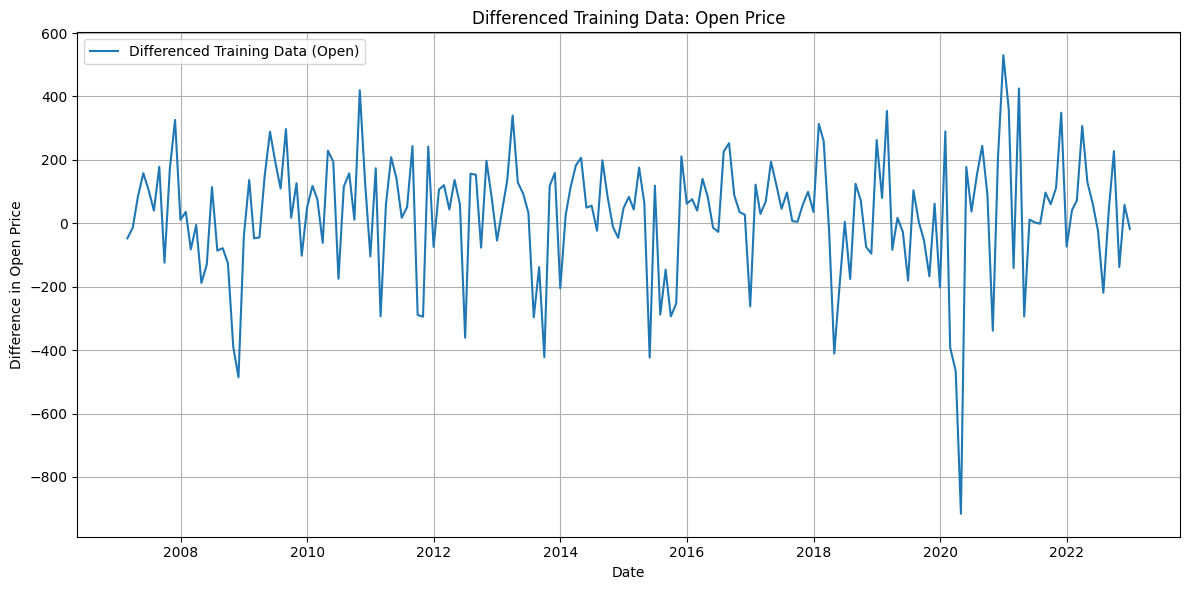

=== ADF Test - Data Train Open (After Differencing) ===
ADF Statistic: -11.743629124349678
p-value: 1.2564868853419257e-21
Kesimpulan: Stasioner


In [65]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# === 1. Differencing pada data Open ===
y_train_open_diff = y_train_open.diff().dropna()

# === 2. Plot data setelah differencing ===
plt.figure(figsize=(12, 6))
plt.plot(y_train_open_diff.index, y_train_open_diff, label='Differenced Training Data (Open)')
plt.title('Differenced Training Data: Open Price')
plt.xlabel('Date')
plt.ylabel('Difference in Open Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 3. ADF Test pada data hasil differencing ===
print("=== ADF Test - Data Train Open (After Differencing) ===")
result_diff_open = adfuller(y_train_open_diff, autolag='AIC')
print("ADF Statistic:", result_diff_open[0])
print("p-value:", result_diff_open[1])
print("Kesimpulan:", "Stasioner" if result_diff_open[1] < 0.05 else "Tidak Stasioner")

Plot hasil differencing menunjukkan bahwa data sudah stasioner terhadap nilai tengah. Selanjutnya, dilakukan pengecekan lebih lanjut menggunakan plot ACF dan uji ADF.

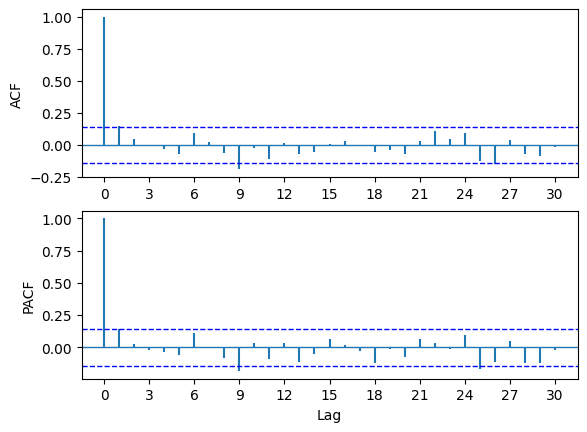

ADF TEST (differenced data): 9.653970894328986e-22


In [18]:
# prompt: PLOT ACF PACF DAN UJI ADF

import matplotlib.pyplot as plt
#Plot acf dan pacf data train
acf_pacf_fig(y_train_diff, both=True, lag=30); plt.show()
#ADF DATA TRAIN CLOSE (Differenced)
result_diff = adfuller(y_train_diff, autolag='AIC')
p_value_diff = float(result_diff[1])
print("ADF TEST (differenced data):", p_value_diff)


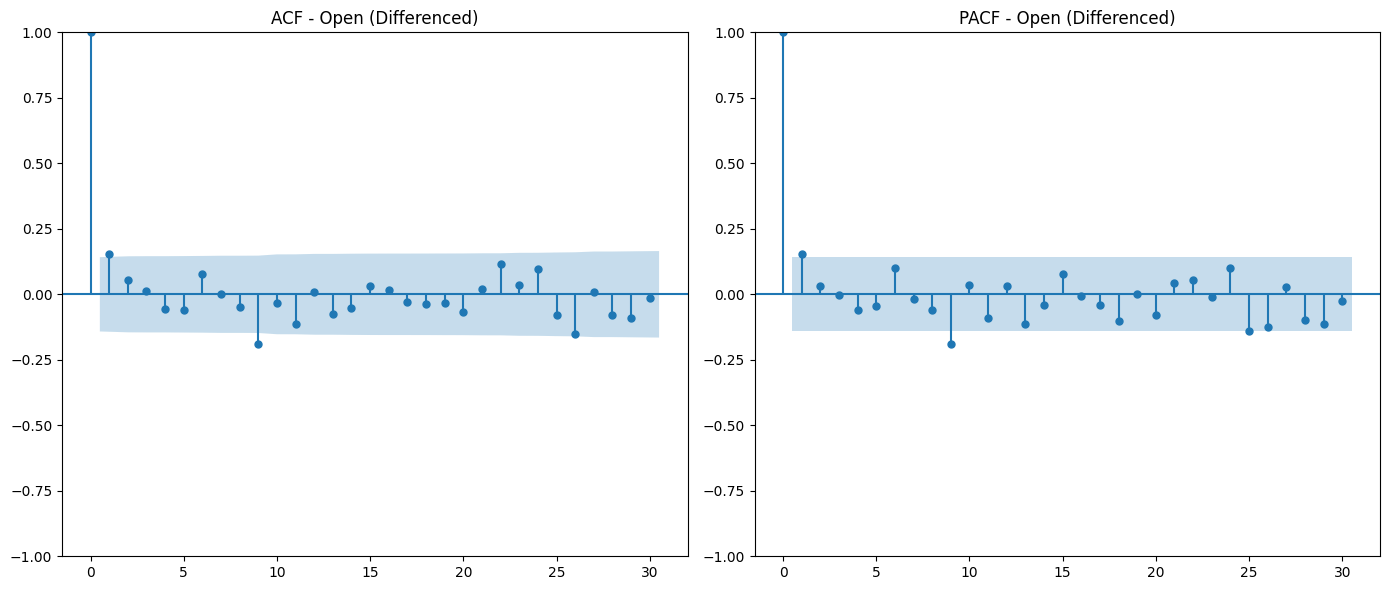

=== ADF TEST (Open - Differenced) ===
ADF Statistic: -11.743629124349678
p-value: 1.2564868853419257e-21
Kesimpulan: Stasioner


In [66]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# === Differencing data Open ===
y_train_open_diff = y_train_open.diff().dropna()

# === Plot ACF dan PACF untuk data differenced Open ===
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_acf(y_train_open_diff, ax=plt.gca(), lags=30)
plt.title('ACF - Open (Differenced)')

plt.subplot(1, 2, 2)
plot_pacf(y_train_open_diff, ax=plt.gca(), lags=30, method='ywm')
plt.title('PACF - Open (Differenced)')

plt.tight_layout()
plt.show()

# === Uji ADF pada data Open setelah differencing ===
result_open_diff = adfuller(y_train_open_diff, autolag='AIC')
print("=== ADF TEST (Open - Differenced) ===")
print("ADF Statistic:", result_open_diff[0])
print("p-value:", result_open_diff[1])
print("Kesimpulan:", "Stasioner" if result_open_diff[1] < 0.05 else "Tidak Stasioner")

Berdasarkan plot ACF yang menunjukkan pola cut-off pada lag 1, dapat disimpulkan bahwa data sudah stasioner terhadap nilai tengah. Nilai ADF < 0.05 sehingga data stasioner terhadap nilai tengah

Lambda Box-Cox (setelah differencing): 1.7638569790720773


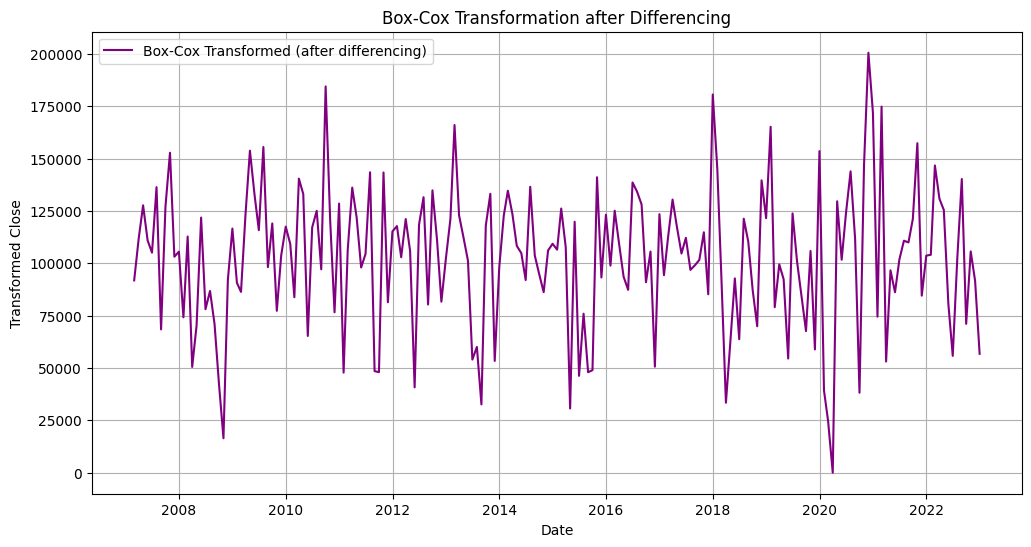

In [19]:
from scipy.stats import boxcox, boxcox_normmax
import matplotlib.pyplot as plt

# Geser data differenced agar semua nilai > 0
y_diff_shifted = y_train_diff + abs(min(y_train_diff)) + 1

# Estimasi lambda terbaik
lambda_boxcox_diff = boxcox_normmax(y_diff_shifted, method='mle')
print("Lambda Box-Cox (setelah differencing):", lambda_boxcox_diff)

# Transformasi Box-Cox
y_diff_boxcox = boxcox(y_diff_shifted, lmbda=lambda_boxcox_diff)

# Plot hasil transformasi Box-Cox
plt.figure(figsize=(12, 6))
plt.plot(y_train_diff.index, y_diff_boxcox, label='Box-Cox Transformed (after differencing)', color='purple')
plt.title('Box-Cox Transformation after Differencing')
plt.xlabel('Date')
plt.ylabel('Transformed Close')
plt.legend()
plt.grid(True)
plt.show()

Lambda Box-Cox (Open - setelah differencing): 1.681855993450177


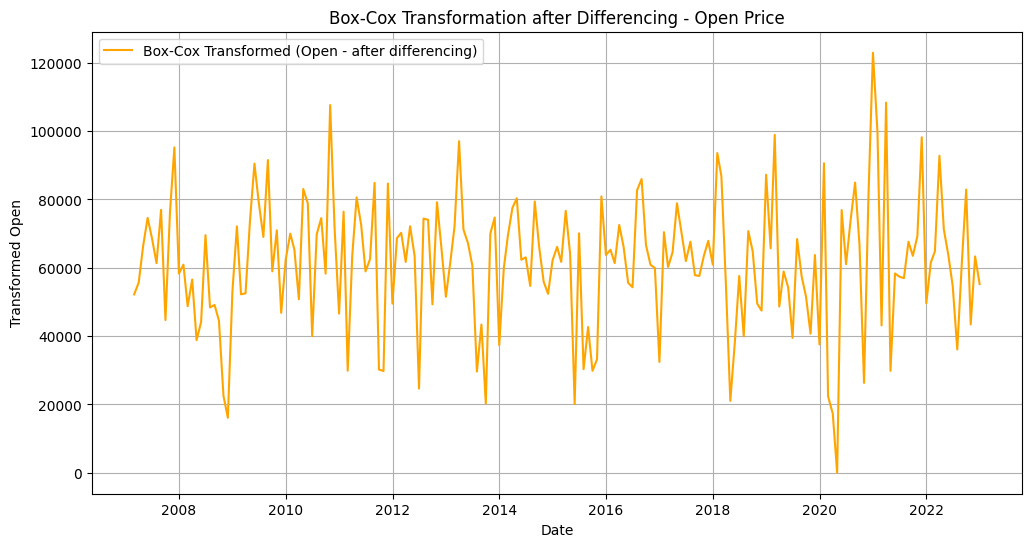

In [67]:
from scipy.stats import boxcox, boxcox_normmax
import matplotlib.pyplot as plt

# Lakukan differencing data Open
y_train_open_diff = y_train_open.diff().dropna()

# Geser data agar semua nilai > 0 sebelum transformasi Box-Cox
y_open_diff_shifted = y_train_open_diff + abs(min(y_train_open_diff)) + 1

# Estimasi nilai lambda terbaik untuk Box-Cox
lambda_boxcox_open = boxcox_normmax(y_open_diff_shifted, method='mle')
print("Lambda Box-Cox (Open - setelah differencing):", lambda_boxcox_open)

# Transformasi Box-Cox pada data yang sudah di-shift
y_open_boxcox = boxcox(y_open_diff_shifted, lmbda=lambda_boxcox_open)

# Plot hasil transformasi Box-Cox
plt.figure(figsize=(12, 6))
plt.plot(y_train_open_diff.index, y_open_boxcox, label='Box-Cox Transformed (Open - after differencing)', color='orange')
plt.title('Box-Cox Transformation after Differencing - Open Price')
plt.xlabel('Date')
plt.ylabel('Transformed Open')
plt.legend()
plt.grid(True)
plt.show()

In [68]:
from statsmodels.stats.diagnostic import het_arch

# Uji ARCH pada data Close
arch_test_close = het_arch(y_train_diff)
stat_close = arch_test_close[0]
pval_close = arch_test_close[1]

print("=== Uji ARCH - Close ===")
print(f"Statistik ARCH: {stat_close}")
print(f"p-value: {pval_close}")
if pval_close < 0.05:
    print("Terdapat gejala heteroskedastisitas pada Close.\n")
else:
    print("Tidak terdapat gejala heteroskedastisitas pada Close.\n")

# Uji ARCH pada data Open
y_train_open_diff = y_train_open.diff().dropna()
arch_test_open = het_arch(y_train_open_diff)
stat_open = arch_test_open[0]
pval_open = arch_test_open[1]

print("=== Uji ARCH - Open ===")
print(f"Statistik ARCH: {stat_open}")
print(f"p-value: {pval_open}")
if pval_open < 0.05:
    print("Terdapat gejala heteroskedastisitas pada Open.")
else:
    print("Tidak terdapat gejala heteroskedastisitas pada Open.")

=== Uji ARCH - Close ===
Statistik ARCH: 12.731439602887832
p-value: 0.2390773477332434
Tidak terdapat gejala heteroskedastisitas pada Close.

=== Uji ARCH - Open ===
Statistik ARCH: 14.612666730792384
p-value: 0.14683432532421364
Tidak terdapat gejala heteroskedastisitas pada Open.



Untuk mengecek kestasioneran terhadap ragam, dilakukan analisis terhadap nilai lambda menggunakan transformasi Box-Cox. Sebelum transformasi dilakukan, ditambahkan konstanta pada data karena metode Box-Cox tidak dapat diterapkan pada data yang mengandung nilai nol atau negatif. Hasil transformasi menunjukkan bahwa nilai lambda sebesar 1, yang mengindikasikan bahwa data telah stasioner terhadap ragam. Hal ini diperkuat oleh hasil uji ARCH, di mana p-value yang diperoleh lebih besar dari 0.05, sehingga tidak terdapat indikasi adanya gejala heteroskedastisitas.”


# ARIMA

## IDENTIFIKASI MODEL TERBAIK

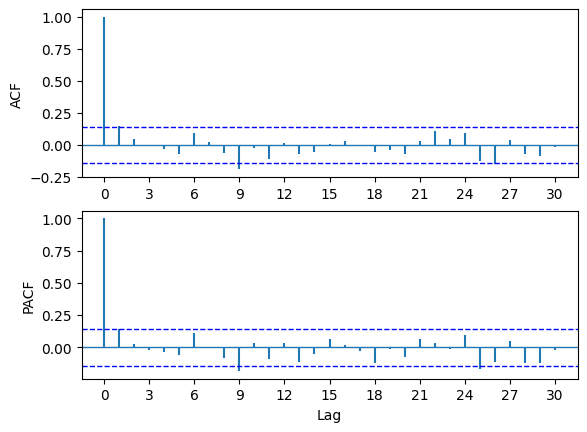

In [70]:
# prompt: plot acf dan pacf hasil differencing CLOSE

import matplotlib.pyplot as plt
# Plot ACF and PACF of the differenced data
acf_pacf_fig(y_train_diff, both=True, lag=30); plt.show()


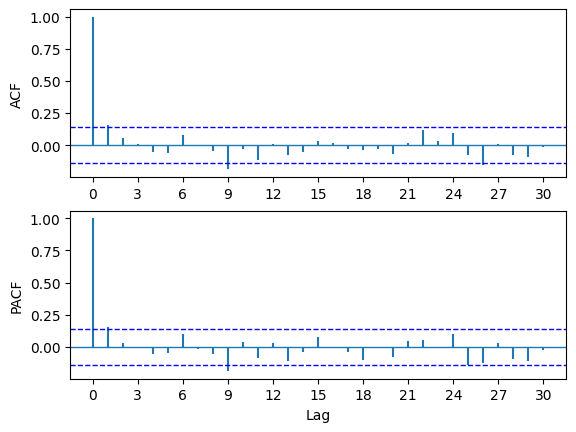

In [71]:
# prompt: plot acf dan pacf hasil differencing OPEN

import matplotlib.pyplot as plt
# Plot ACF and PACF of the differenced data
acf_pacf_fig(y_train_open_diff, both=True, lag=30); plt.show()

Plot ACF yang menunjukkan cut-off di lag 1 mengindikasikan adanya komponen MA(1). Sementara itu, plot PACF yang mengalami cut-off di lag 1 AR(1).
Dari hasil tersebut, maka model tentatif yang dapat di uji adalah
*   ARIMA (0,1,1)
*   ARIMA (1,1,0)

## ARIMA (0,1,1)

In [72]:
#MODEL MA(1) CLOSE
model_ma1 = ARIMA(y_train_diff, order=(0,0,1)).fit()
print(model_ma1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  191
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1276.706
Date:                Sun, 04 May 2025   AIC                           2559.412
Time:                        05:21:48   BIC                           2569.169
Sample:                    02-28-2007   HQIC                          2563.364
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.5842     18.007      1.476      0.140      -8.709      61.877
ma.L1          0.1343      0.062      2.173      0.030       0.013       0.255
sigma2      3.744e+04   3428.712     10.921      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)


In [73]:
#MODEL MA(1) OPEN
model_ma1open = ARIMA(y_train_open_diff, order=(0,0,1)).fit()
print(model_ma1open.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                  191
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1272.583
Date:                Sun, 04 May 2025   AIC                           2551.167
Time:                        05:22:32   BIC                           2560.924
Sample:                    02-28-2007   HQIC                          2555.119
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.5447     17.362      1.587      0.113      -6.484      61.573
ma.L1          0.1421      0.059      2.425      0.015       0.027       0.257
sigma2      3.586e+04   3007.641     11.924      0.0

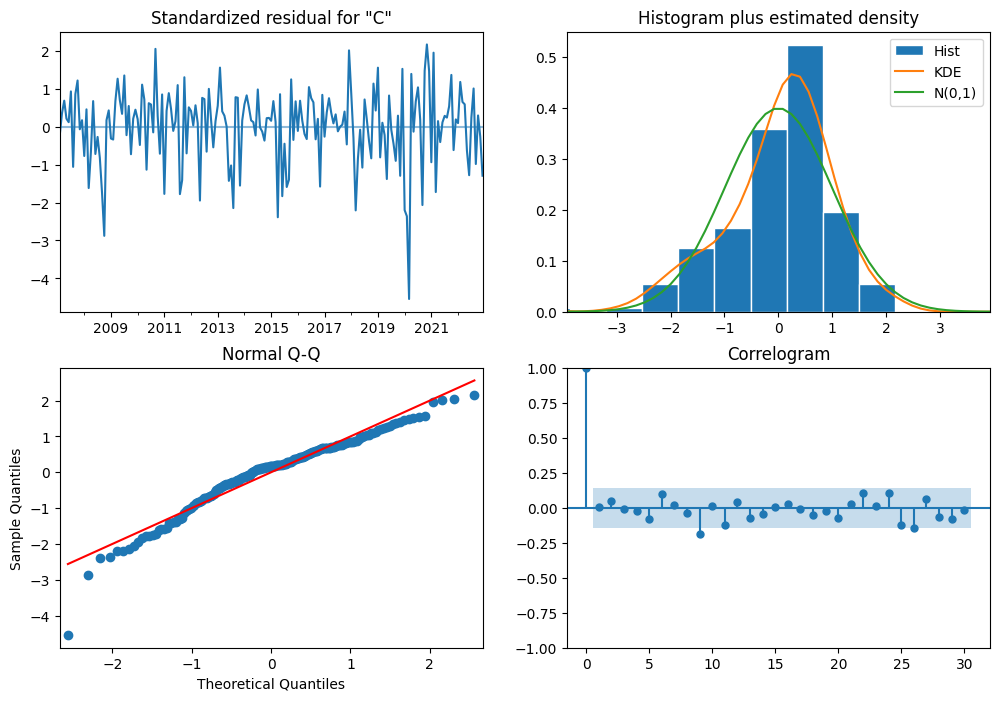


=== UJI STATISTIK RESIDUAL (MA1) ===
Uji Autokorelasi (ARCH Test) - p-value: 0.13725932047413292
Uji Keacakan Residual (Ljung-Box Test) - Statistic: 35.20173074162213 p-value: 0.23537425278684218
Uji Normalitas (Shapiro-Wilk) - Statistic: 0.9540555147053446 p-value: 7.571166557609669e-06
Uji Normalitas (Jarque-Bera) - JB Statistic: 50.86954428730266 p-value: 8.991223836199994e-12


In [74]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import shapiro, jarque_bera, norm
from statsmodels.graphics.tsaplots import plot_acf

# === 1. PLOT DIAGNOSTIK RESIDUAL MA CLOSE===
model_ma1.plot_diagnostics(figsize=(12, 8), lags=30)
plt.show()

# === 2. UJI STATISTIK RESIDUAL ===
print("\n=== UJI STATISTIK RESIDUAL (MA1) ===")

# 2.1 UJI AUTOKORELASI (ARCH Test)
arch_pvalue = het_arch(model_ma1.resid, nlags=10)[1]
print("Uji Autokorelasi (ARCH Test) - p-value:", arch_pvalue)

# 2.2 UJI KEACAKAN (Ljung-Box Test)
ljungbox_result = acorr_ljungbox(model_ma1.resid, lags=[30], return_df=True)
print("Uji Keacakan Residual (Ljung-Box Test) - Statistic:", ljungbox_result['lb_stat'].values[0],
      "p-value:", ljungbox_result['lb_pvalue'].values[0])

# 2.3 UJI NORMALITAS (Shapiro-Wilk)
shapiro_stat, shapiro_pval = shapiro(model_ma1.resid)
print("Uji Normalitas (Shapiro-Wilk) - Statistic:", shapiro_stat, "p-value:", shapiro_pval)

# 2.4 UJI NORMALITAS (Jarque-Bera)
jb_stat, jb_pval = jarque_bera(model_ma1.resid)
print("Uji Normalitas (Jarque-Bera) - JB Statistic:", jb_stat, "p-value:", jb_pval)


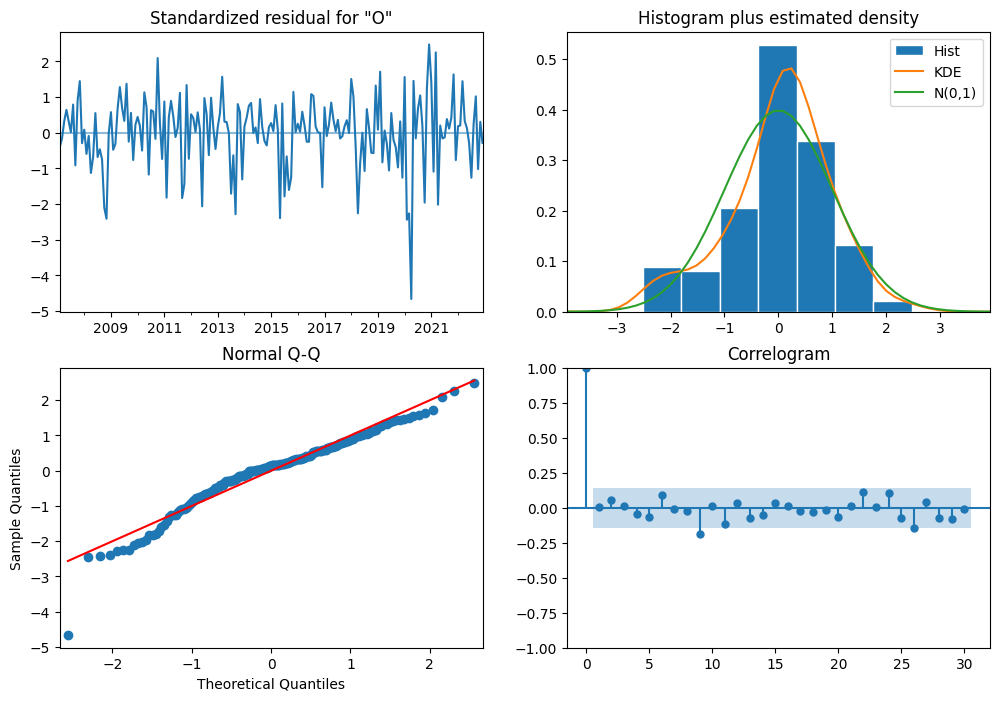


=== UJI STATISTIK RESIDUAL (MA(1) OPEN) ===
Uji Autokorelasi (ARCH Test) - p-value: 0.07352096667986469
Uji Keacakan Residual (Ljung-Box Test) - Statistic: 31.871594395725914 p-value: 0.3735230770186038
Uji Normalitas (Shapiro-Wilk) - Statistic: 0.9544932660972755 p-value: 8.363185139366345e-06
Uji Normalitas (Jarque-Bera) - JB Statistic: 59.0213112438441 p-value: 1.5264588671917163e-13


In [76]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import shapiro, jarque_bera
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
# === 1. PLOT DIAGNOSTIK RESIDUAL ===
model_ma1open.plot_diagnostics(figsize=(12, 8), lags=30)
plt.show()

# === 2. UJI STATISTIK RESIDUAL ===
print("\n=== UJI STATISTIK RESIDUAL (MA(1) OPEN) ===")

# 2.1 UJI AUTOKORELASI (ARCH Test)
arch_pvalue = het_arch(model_ma1open.resid, nlags=10)[1]
print("Uji Autokorelasi (ARCH Test) - p-value:", arch_pvalue)

# 2.2 UJI KEACAKAN (Ljung-Box Test)
ljungbox_result = acorr_ljungbox(model_ma1open.resid, lags=[30], return_df=True)
print("Uji Keacakan Residual (Ljung-Box Test) - Statistic:", ljungbox_result['lb_stat'].values[0],
      "p-value:", ljungbox_result['lb_pvalue'].values[0])

# 2.3 UJI NORMALITAS (Shapiro-Wilk)
shapiro_stat, shapiro_pval = shapiro(model_ma1open.resid)
print("Uji Normalitas (Shapiro-Wilk) - Statistic:", shapiro_stat, "p-value:", shapiro_pval)

# 2.4 UJI NORMALITAS (Jarque-Bera)
jb_stat, jb_pval = jarque_bera(model_ma1open.resid)
print("Uji Normalitas (Jarque-Bera) - JB Statistic:", jb_stat, "p-value:", jb_pval)

## ARIMA (1,1,0)

In [24]:
#MODEL AR(1)
model_ar1 = ARIMA(y_train_diff, order=(1,0,0)).fit()
print(model_ar1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  191
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1276.569
Date:                Sun, 04 May 2025   AIC                           2559.137
Time:                        04:38:57   BIC                           2568.894
Sample:                    02-28-2007   HQIC                          2563.089
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.6668     18.598      1.434      0.152      -9.784      63.117
ar.L1          0.1443      0.060      2.420      0.016       0.027       0.261
sigma2      3.758e+04   3590.844     10.465      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)


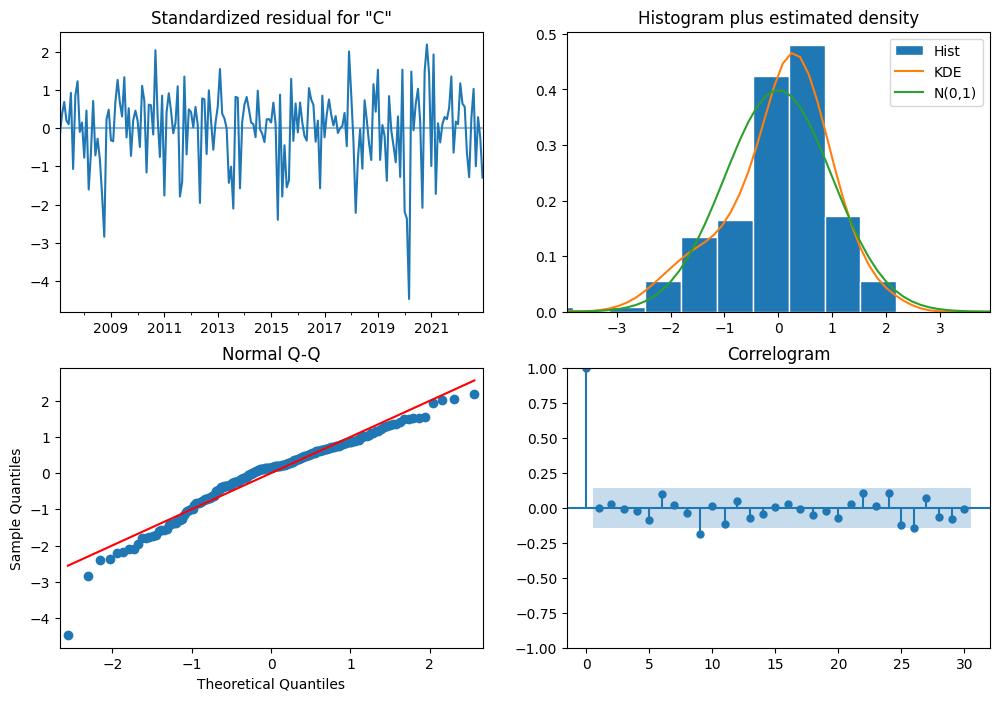


=== UJI STATISTIK RESIDUAL (AR1) ===
Uji Autokorelasi (ARCH Test) - p-value: 0.09909822276904186
Uji Keacakan Residual (Ljung-Box Test) - Statistic: 35.033818779186696 p-value: 0.24141196970288895
Uji Normalitas (Shapiro-Wilk) - Statistic: 0.9565819609786309 p-value: 1.3536975518295612e-05
Uji Normalitas (Jarque-Bera) - JB Statistic: 45.8694190253087 p-value: 1.09542390618132e-10


In [25]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import shapiro, jarque_bera, norm
from statsmodels.graphics.tsaplots import plot_acf

# === 1. PLOT DIAGNOSTIK RESIDUAL ===
model_ar1.plot_diagnostics(figsize=(12, 8), lags=30)
plt.show()

# === 2. UJI STATISTIK RESIDUAL ===
print("\n=== UJI STATISTIK RESIDUAL (AR1) ===")

# 2.1 UJI AUTOKORELASI (ARCH Test)
arch_pvalue = het_arch(model_ar1.resid, nlags=10)[1]
print("Uji Autokorelasi (ARCH Test) - p-value:", arch_pvalue)

# 2.2 UJI KEACAKAN (Ljung-Box Test)
ljungbox_result = acorr_ljungbox(model_ar1.resid, lags=[30], return_df=True)
print("Uji Keacakan Residual (Ljung-Box Test) - Statistic:", ljungbox_result['lb_stat'].values[0],
      "p-value:", ljungbox_result['lb_pvalue'].values[0])

# 2.3 UJI NORMALITAS (Shapiro-Wilk)
shapiro_stat, shapiro_pval = shapiro(model_ar1.resid)
print("Uji Normalitas (Shapiro-Wilk) - Statistic:", shapiro_stat, "p-value:", shapiro_pval)

# 2.4 UJI NORMALITAS (Jarque-Bera)
jb_stat, jb_pval = jarque_bera(model_ar1.resid)
print("Uji Normalitas (Jarque-Bera) - JB Statistic:", jb_stat, "p-value:", jb_pval)


In [78]:
#MODEL AR(1) OPEN
model_ar1open = ARIMA(y_train_open_diff, order=(1,0,0)).fit()
print(model_ar1open.summary())

                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                  191
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1272.410
Date:                Sun, 04 May 2025   AIC                           2550.820
Time:                        05:26:12   BIC                           2560.577
Sample:                    02-28-2007   HQIC                          2554.772
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.5798     17.992      1.533      0.125      -7.684      62.843
ar.L1          0.1533      0.057      2.709      0.007       0.042       0.264
sigma2      3.596e+04   3157.800     11.387      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)


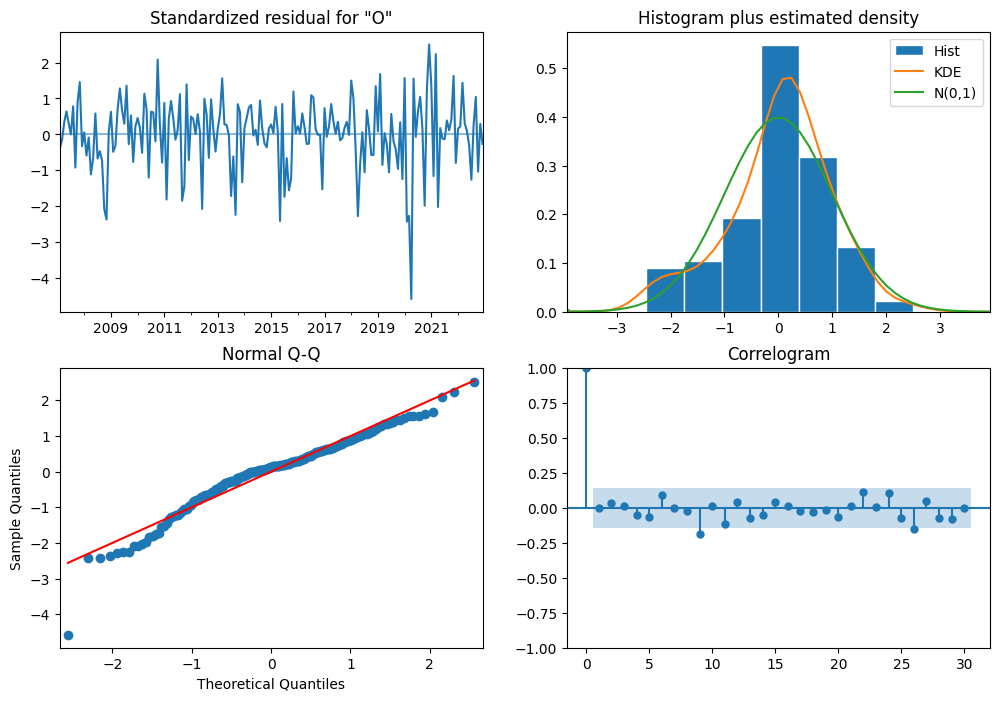


=== UJI STATISTIK RESIDUAL (AR1)OPEN ===
Uji Autokorelasi (ARCH Test) - p-value: 0.04877382890905506
Uji Keacakan Residual (Ljung-Box Test) - Statistic: 31.498390719532033 p-value: 0.39121205820215293
Uji Normalitas (Shapiro-Wilk) - Statistic: 0.9569445642550605 p-value: 1.4734815750185214e-05
Uji Normalitas (Jarque-Bera) - JB Statistic: 52.39826552710299 p-value: 4.18659750352601e-12


In [80]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import shapiro, jarque_bera, norm
from statsmodels.graphics.tsaplots import plot_acf

# === 1. PLOT DIAGNOSTIK RESIDUAL ===
model_ar1open.plot_diagnostics(figsize=(12, 8), lags=30)
plt.show()

# === 2. UJI STATISTIK RESIDUAL ===
print("\n=== UJI STATISTIK RESIDUAL (AR1)OPEN ===")

# 2.1 UJI AUTOKORELASI (ARCH Test)
arch_pvalue = het_arch(model_ar1.resid, nlags=10)[1]
print("Uji Autokorelasi (ARCH Test) - p-value:", arch_pvalue)

# 2.2 UJI KEACAKAN (Ljung-Box Test)
ljungbox_result = acorr_ljungbox(model_ar1.resid, lags=[30], return_df=True)
print("Uji Keacakan Residual (Ljung-Box Test) - Statistic:", ljungbox_result['lb_stat'].values[0],
      "p-value:", ljungbox_result['lb_pvalue'].values[0])

# 2.3 UJI NORMALITAS (Shapiro-Wilk)
shapiro_stat, shapiro_pval = shapiro(model_ar1.resid)
print("Uji Normalitas (Shapiro-Wilk) - Statistic:", shapiro_stat, "p-value:", shapiro_pval)

# 2.4 UJI NORMALITAS (Jarque-Bera)
jb_stat, jb_pval = jarque_bera(model_ar1.resid)
print("Uji Normalitas (Jarque-Bera) - JB Statistic:", jb_stat, "p-value:", jb_pval)

Kesimpulan Model (0,1,1) dan (1,1,0)

Memenuhi Asumsi:

	* Homoskedastisitas → Varians residual konstan (p-value > 0.05) tidak ada heteroskedastisitas.
	* Tidak ada autokorelasi signifikan → p-value > 0.05, sehingga gagal menolak H₀, yang berarti residual bersifat white noise.
	* Residual acak → p-value > 0.05, sehingga residual dianggap acak tanpa pola sistematis kecuali model AR 1 OPEN.

Tidak Memenuhi Asumsi:

	* Normalitas residual tidak terpenuhi → Uji Shapiro-Wilk dan Jarque-Bera menunjukkan p-value < 0.05, sehingga H₀ ditolak dan residual tidak berdistribusi normal.
	* Namun, karena jumlah data besar, berdasarkan Dalil Limit Pusat, asumsi normalitas dapat diabaikan.

Kesimpulannya Model (0,1,1) dan (1,1,0) dapat digunakan untuk baselin analisis time series.

In [81]:
import pandas as pd

# Create a DataFrame to store AIC and BIC values
results_df = pd.DataFrame(columns=['Model', 'AIC', 'BIC'])

# Append MA(1) model results
results_df = pd.concat([results_df, pd.DataFrame([{'Model': 'MA(1)', 'AIC': model_ma1.aic, 'BIC': model_ma1.bic}])], ignore_index=True)

# Append AR(1) model results
results_df = pd.concat([results_df, pd.DataFrame([{'Model': 'AR(1)', 'AIC': model_ar1.aic, 'BIC': model_ar1.bic}])], ignore_index=True)

# Append MA(1) model results for Open data
results_df = pd.concat([results_df, pd.DataFrame([{'Model': 'MA(1) Open', 'AIC': model_ma1open.aic, 'BIC': model_ma1open.bic}])], ignore_index=True)

# Append AR(1) model results for Open data
results_df = pd.concat([results_df, pd.DataFrame([{'Model': 'AR(1) Open', 'AIC': model_ar1open.aic, 'BIC': model_ar1open.bic}])], ignore_index=True)

# Display the DataFrame
print(results_df)

        Model          AIC          BIC
0       MA(1)  2559.411884  2569.168705
1       AR(1)  2550.820496  2560.577316
2  MA(1) Open  2551.166703  2560.923523
3  AR(1) Open  2550.820496  2560.577316


<ipython-input-81-10422a32f709>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([{'Model': 'MA(1)', 'AIC': model_ma1.aic, 'BIC': model_ma1.bic}])], ignore_index=True)


Berdasarkan nilai AIC dan BIC  dari pemilihan model tentatif, model terbaik adalah Model AR(1) untuk data CLOSE dan untuk data OPEN adalah MA(1) karena hanya dia yang memenuhi seluruh asumsi.

#OVERFITTING MODEL ARIMA
Model yang dilakukan overfitting ARIMAX (1,1,0) data CLOSE

*   ARIMAX (1,1,1)
*   ARIMAX (2,1,1)
*   ARIMAX (2,1,0)

Model yang dilakukan overfitting ARIMAX (0,1,1) data OPEN

*   ARIMAX (1,1,1)

In [28]:
#MODEL ARIMA(1,1,1)
model_arima1 = ARIMA(y_train_diff, order=(1,0,1)).fit()
print(model_arima1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  191
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1276.523
Date:                Sun, 04 May 2025   AIC                           2561.045
Time:                        04:40:26   BIC                           2574.054
Sample:                    02-28-2007   HQIC                          2566.314
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.5602     18.877      1.407      0.159     -10.438      63.559
ar.L1          0.2664      0.463      0.575      0.565      -0.642       1.175
ma.L1         -0.1242      0.481     -0.258      0.7

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)


In [82]:
#MODEL ARIMA(1,1,1) OPEN
model_arima1open = ARIMA(y_train_open_diff, order=(1,0,1)).fit()
print(model_arima1open.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                  191
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1272.344
Date:                Sun, 04 May 2025   AIC                           2552.688
Time:                        05:38:27   BIC                           2565.697
Sample:                    02-28-2007   HQIC                          2557.957
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.5796     18.756      1.470      0.141      -9.181      64.340
ar.L1          0.3093      0.418      0.739      0.460      -0.511       1.129
ma.L1         -0.1592      0.438     -0.364      0.7

In [31]:
#MODEL ARIMA(2,1,1)
model_arima21 = ARIMA(y_train_diff, order=(2,0,1)).fit()
print(model_arima21.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  191
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -1275.538
Date:                Sun, 04 May 2025   AIC                           2561.077
Time:                        04:44:33   BIC                           2577.338
Sample:                    02-28-2007   HQIC                          2567.663
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.5189     19.015      1.395      0.163     -10.751      63.788
ar.L1         -0.7974      0.137     -5.830      0.000      -1.066      -0.529
ar.L2          0.1716      0.062      2.748      0.0

In [32]:
#MODEL ARIMA(2,1,0)
model_arima2 = ARIMA(y_train_diff, order=(2,0,0)).fit()
print(model_arima2.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  191
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1276.507
Date:                Sun, 04 May 2025   AIC                           2561.013
Time:                        04:44:51   BIC                           2574.022
Sample:                    02-28-2007   HQIC                          2566.282
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.5577     18.961      1.401      0.161     -10.605      63.721
ar.L1          0.1406      0.061      2.312      0.021       0.021       0.260
ar.L2          0.0252      0.068      0.372      0.7

## UJI DIAGNOSTIK MODEL

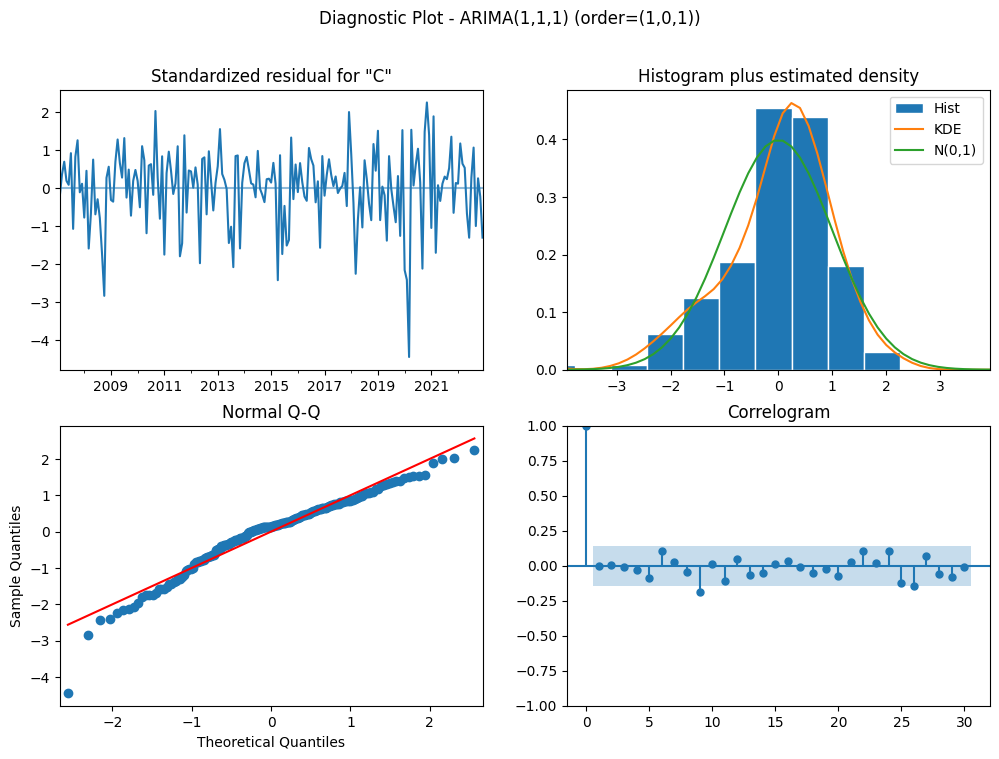

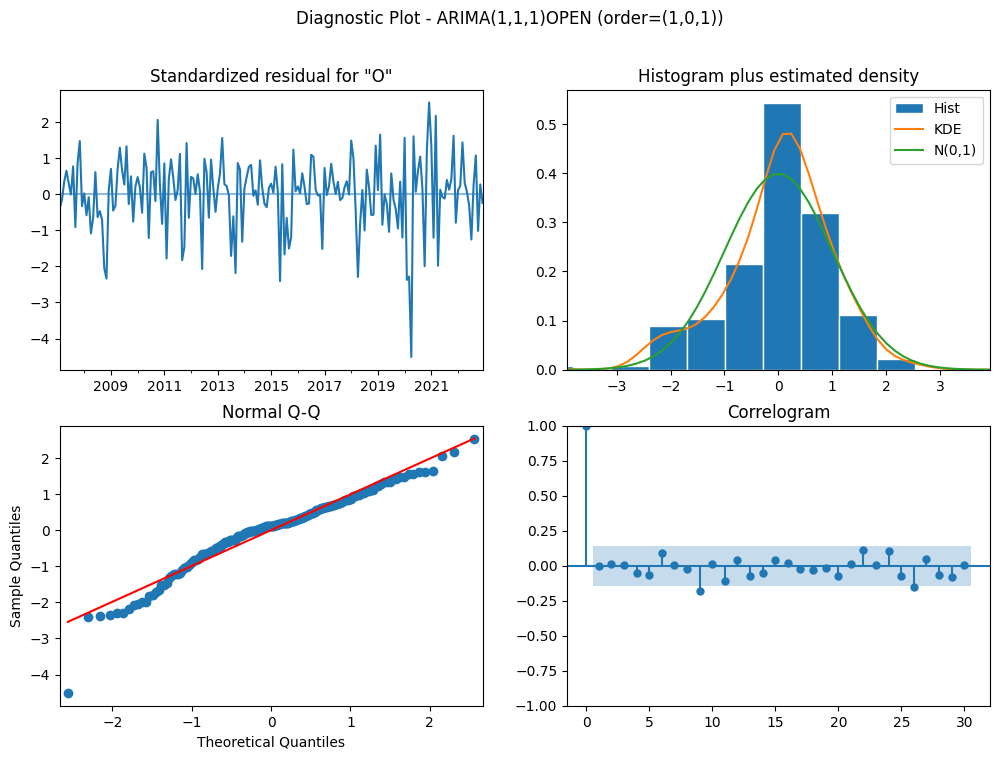

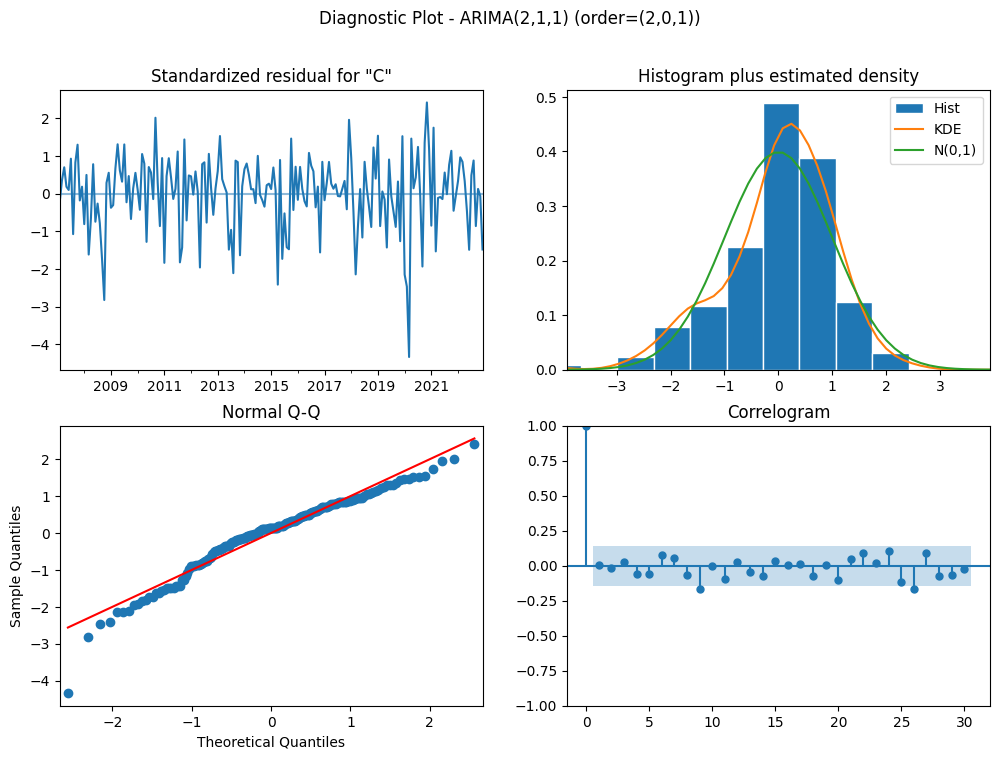

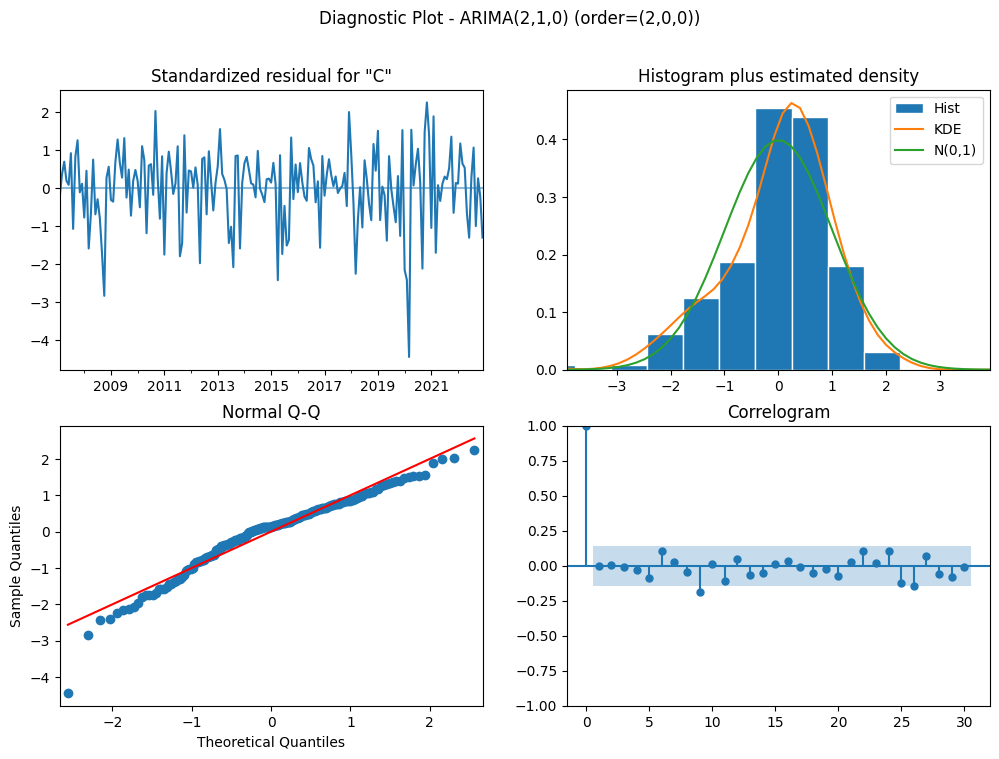

In [83]:
# === 1. PLOT DIAGNOSTIK RESIDUAL ===

# ARIMA(1,1,1)
model_arima1.plot_diagnostics(figsize=(12, 8), lags=30)
plt.suptitle("Diagnostic Plot - ARIMA(1,1,1) (order=(1,0,1))")
plt.show()

# ARIMA(1,1,1) OPEN
model_arima1open.plot_diagnostics(figsize=(12, 8), lags=30)
plt.suptitle("Diagnostic Plot - ARIMA(1,1,1)OPEN (order=(1,0,1))")
plt.show()

# ARIMA(2,1,1)
model_arima21.plot_diagnostics(figsize=(12, 8), lags=30)
plt.suptitle("Diagnostic Plot - ARIMA(2,1,1) (order=(2,0,1))")
plt.show()

# ARIMA(2,1,0)
model_arima2.plot_diagnostics(figsize=(12, 8), lags=30)
plt.suptitle("Diagnostic Plot - ARIMA(2,1,0) (order=(2,0,0))")
plt.show()

In [84]:
# === 2. UJI STATISTIK RESIDUAL ===
print("\n=== UJI STATISTIK RESIDUAL (ARIMA dengan y_train_diff) ===")

# --- ARIMA(1,1,1) ---
print("\n--- Model ARIMA(1,1,1) (order=(1,0,1)) ---")
print("ARCH Test p-value:", het_arch(model_arima1.resid, nlags=10)[1])
ljungbox_1 = acorr_ljungbox(model_arima1.resid, lags=[30], return_df=True)
print("Ljung-Box Test - Statistic:", ljungbox_1['lb_stat'].values[0],
      "p-value:", ljungbox_1['lb_pvalue'].values[0])
shapiro_stat_1, shapiro_pval_1 = shapiro(model_arima1.resid)
print("Shapiro-Wilk - Statistic:", shapiro_stat_1, "p-value:", shapiro_pval_1)
jb_stat_1, jb_pval_1 = jarque_bera(model_arima1.resid)
print("Jarque-Bera - Statistic:", jb_stat_1, "p-value:", jb_pval_1)

# --- ARIMA(1,1,1) OPEN---
print("\n--- Model ARIMA(1,1,1) (order=(1,0,1)) ---")
print("ARCH Test p-value:", het_arch(model_arima1open.resid, nlags=10)[1])
ljungbox_1 = acorr_ljungbox(model_arima1open.resid, lags=[30], return_df=True)
print("Ljung-Box Test - Statistic:", ljungbox_1['lb_stat'].values[0],
      "p-value:", ljungbox_1['lb_pvalue'].values[0])
shapiro_stat_1, shapiro_pval_1 = shapiro(model_arima1open.resid)
print("Shapiro-Wilk - Statistic:", shapiro_stat_1, "p-value:", shapiro_pval_1)
jb_stat_1, jb_pval_1 = jarque_bera(model_arima1open.resid)
print("Jarque-Bera - Statistic:", jb_stat_1, "p-value:", jb_pval_1)

# --- ARIMA(2,1,1) ---
print("\n--- Model ARIMA(2,1,1) (order=(2,0,1)) ---")
print("ARCH Test p-value:", het_arch(model_arima21.resid, nlags=10)[1])
ljungbox_2 = acorr_ljungbox(model_arima21.resid, lags=[30], return_df=True)
print("Ljung-Box Test - Statistic:", ljungbox_2['lb_stat'].values[0],
      "p-value:", ljungbox_2['lb_pvalue'].values[0])
shapiro_stat_2, shapiro_pval_2 = shapiro(model_arima21.resid)
print("Shapiro-Wilk - Statistic:", shapiro_stat_2, "p-value:", shapiro_pval_2)
jb_stat_2, jb_pval_2 = jarque_bera(model_arima21.resid)
print("Jarque-Bera - Statistic:", jb_stat_2, "p-value:", jb_pval_2)

# --- ARIMA(2,1,0) ---
print("\n--- Model ARIMA(2,1,0) (order=(2,0,0)) ---")
print("ARCH Test p-value:", het_arch(model_arima2.resid, nlags=10)[1])
ljungbox_3 = acorr_ljungbox(model_arima2.resid, lags=[30], return_df=True)
print("Ljung-Box Test - Statistic:", ljungbox_3['lb_stat'].values[0],
      "p-value:", ljungbox_3['lb_pvalue'].values[0])
shapiro_stat_3, shapiro_pval_3 = shapiro(model_arima2.resid)
print("Shapiro-Wilk - Statistic:", shapiro_stat_3, "p-value:", shapiro_pval_3)
jb_stat_3, jb_pval_3 = jarque_bera(model_arima2.resid)
print("Jarque-Bera - Statistic:", jb_stat_3, "p-value:", jb_pval_3)


=== UJI STATISTIK RESIDUAL (ARIMA dengan y_train_diff) ===

--- Model ARIMA(1,1,1) (order=(1,0,1)) ---
ARCH Test p-value: 0.07046560539960672
Ljung-Box Test - Statistic: 35.03952314058472 p-value: 0.24120516900615538
Shapiro-Wilk - Statistic: 0.9583129243761489 p-value: 2.0357144084024702e-05
Jarque-Bera - Statistic: 43.21403939536219 p-value: 4.132287931931717e-10

--- Model ARIMA(1,1,1) (order=(1,0,1)) ---
ARCH Test p-value: 0.034104732424579905
Ljung-Box Test - Statistic: 31.29324105322089 p-value: 0.40109517599618166
Shapiro-Wilk - Statistic: 0.9582437947157583 p-value: 2.0024927562284915e-05
Jarque-Bera - Statistic: 49.38678374324298 p-value: 1.887105457803217e-11

--- Model ARIMA(2,1,1) (order=(2,0,1)) ---
ARCH Test p-value: 0.06793457509049734
Ljung-Box Test - Statistic: 34.54313809408575 p-value: 0.25964276915877466
Shapiro-Wilk - Statistic: 0.9599882147408635 p-value: 3.0457987672378182e-05
Jarque-Bera - Statistic: 37.26543819082794 p-value: 8.089336731828797e-09

--- Model A

1. Autokorelasi (Ljung-Box Test):
* Tidak ada autokorelasi tersisa pada seluruh model (p-value > 0.05)
* Residual acak, menunjukkan bahwa pola data telah ditangkap dengan baik oleh model
2. Heteroskedastisitas (ARCH Test):
* model (ARIMA(1,1,1), (2,1,1), (2,1,0)) menunjukkan tidak ada heteroskedastisitas signifikan (p-value > 0.05) kecuali ARIMA(1,1,1) OPEN
3. Normalitas (Shapiro-Wilk & Jarque-Bera):
* Seluruh model memiliki residual yang tidak berdistribusi normal

## MODEL TERBAIK ARIMA

In [85]:
import pandas as pd

# Buat DataFrame perbandingan AIC dan BIC
aic_bic_df = pd.DataFrame([
    {'Model': 'ARIMA(1,1,0)', 'AIC': model_ar1.aic, 'BIC': model_ar1.bic},
    {'Model': 'ARIMA(1,1,1)', 'AIC': model_arima1.aic, 'BIC': model_arima1.bic},
    {'Model': 'ARIMA(2,1,1)', 'AIC': model_arima21.aic, 'BIC': model_arima21.bic},
    {'Model': 'ARIMa(2,1,0)', 'AIC': model_arima2.aic, 'BIC': model_arima2.bic},
    {'Model': 'ARIMa(0,1,1)OPEN', 'AIC': model_ma1open.aic, 'BIC': model_ma1open.bic},
    {'Model': 'ARIMa(1,1,1)OPEN', 'AIC': model_arima1open.aic, 'BIC': model_arima1open.bic},
])

# Tampilkan DataFrame
print(aic_bic_df)

              Model          AIC          BIC
0      ARIMA(1,1,0)  2550.820496  2560.577316
1      ARIMA(1,1,1)  2561.013157  2574.022251
2      ARIMA(2,1,1)  2561.076847  2577.338215
3      ARIMa(2,1,0)  2561.013157  2574.022251
4  ARIMa(0,1,1)OPEN  2551.166703  2560.923523
5  ARIMa(1,1,1)OPEN  2552.687822  2565.696916


	Model ARIMA(1,1,0) dan ARIMA(0,1,1)adalah model terbaik secara keseluruhan, berdasarkan:
	* Nilai AIC dan BIC terendah
	* Parameter signifikan
	* Hasil diagnostik residual yang baik

# PREDIKSI DENGAN MODEL TERBAIK

## FORECASTING DATA TESTING CLOSE

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

# === Forecasting Data Testing dengan ARIMAX(1,1,0) ===
forecast = model_ar1.get_forecast(steps=len(y_test))
predicted_diff = forecast.predicted_mean

# Invers differencing: hasil = nilai terakhir training + kumulatif prediksi selisih
predicted = y_train.iloc[-1] + predicted_diff.cumsum()

# Buat DataFrame hasil prediksi
hasil_forecast = y_test.copy()
hasil_forecast = hasil_forecast.to_frame(name='Aktual')
hasil_forecast['Prediksi'] = predicted.values

# Tampilkan hasil prediksi
print("=== Hasil Prediksi ARIMA(1,1,0) pada Data Testing ===")
print(hasil_forecast)

=== Hasil Prediksi ARIMA(1,1,0) pada Data Testing ===
             Aktual     Prediksi
Date                            
2023-01-31  6839.34  6840.153833
2023-02-28  6843.24  6861.462865
2023-03-31  6805.28  6887.356610
2023-04-30  6915.72  6913.911866
2023-05-31  6633.26  6940.562567
2023-06-30  6661.88  6967.227040
2023-07-31  6931.36  6993.893501
2023-08-31  6953.26  7020.560248
2023-09-30  6939.89  7047.227036
2023-10-31  6752.21  7073.893831
2023-11-30  7080.74  7100.560626
2023-12-31  7272.80  7127.227421
2024-01-31  7207.94  7153.894217
2024-02-29  7316.11  7180.561012
2024-03-31  7288.81  7207.227807
2024-04-30  7234.20  7233.894603
2024-05-31  6970.74  7260.561398
2024-06-30  7063.58  7287.228193
2024-07-31  7255.76  7313.894989
2024-08-31  7670.73  7340.561784
2024-09-30  7527.93  7367.228579
2024-10-31  7574.02  7393.895375
2024-11-30  7114.27  7420.562170
2024-12-31  7079.90  7447.228966


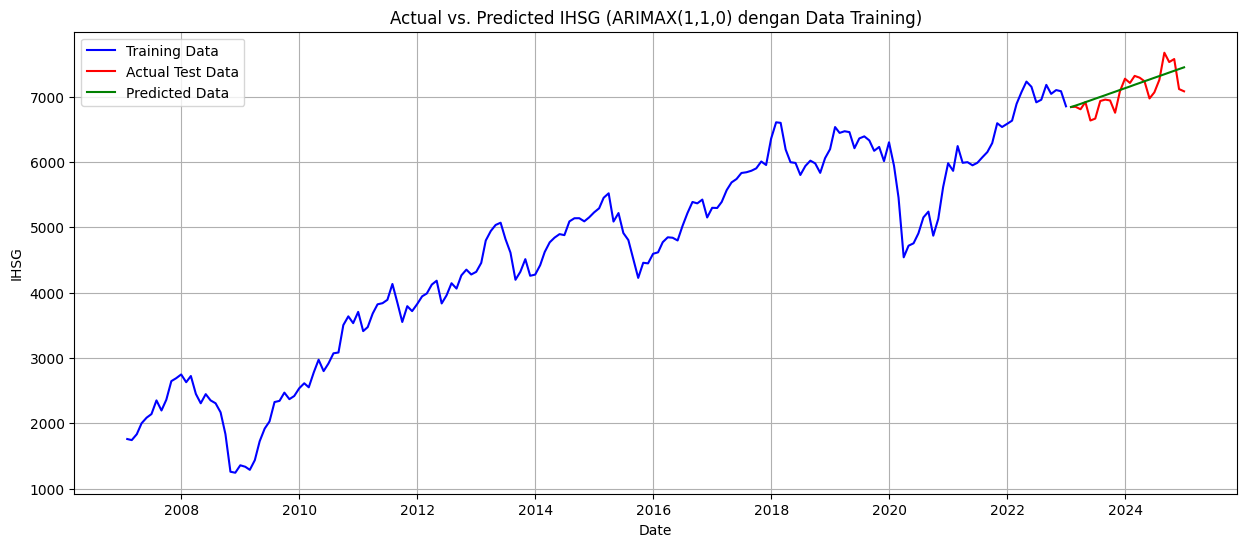

In [39]:
# === Plot data aktual vs. prediksi ===
plt.figure(figsize=(15, 6))

# Plot data training
plt.plot(train.index, y_train, label='Training Data', color='blue')

# Plot data testing aktual
plt.plot(test.index, y_test, label='Actual Test Data', color='red')

# Plot hasil prediksi ARIMAX (sudah transformasi balik)
plt.plot(y_test.index, predicted, label='Predicted Data', color='green')

plt.xlabel('Date')
plt.ylabel('IHSG')
plt.title('Actual vs. Predicted IHSG (ARIMAX(1,1,0) dengan Data Training)')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
# === Evaluasi Model ===
# Invers transformasi (Jika perlu) atau gunakan nilai asli prediksi
mape_test = mean_absolute_percentage_error(y_test, predicted)
mae_test = mean_absolute_error(y_test, predicted)
rmse_test = np.sqrt(mean_squared_error(y_test, predicted))

print("=== Evaluasi Model ARIMAX(1,1,0) pada Data Testing ===")
print(f"MAPE: {mape_test:.4f}")
print(f"MAE : {mae_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")


=== Evaluasi Model ARIMAX(1,1,0) pada Data Testing ===
MAPE: 0.0214
MAE : 151.1467
RMSE: 193.7719


Model ARIMA(1,1,0) menghasilkan prediksi nilai IHSG dengan nilai MAPE sebesar 2.14%. Nilai MAPE yang rendah menunjukkan bahwa model memiliki tingkat kesalahan relatif yang kecil dan cukup akurat dalam memproyeksikan pergerakan IHSG.

## FORECASTING DATA TESTING OPEN

In [88]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

# === Forecasting Data Testing dengan ARIMAX(0,1,1) ===
forecast = model_ma1open.get_forecast(steps=len(y_test_open))
predicted_diff = forecast.predicted_mean

# Invers differencing: hasil = nilai terakhir training + kumulatif prediksi selisih
predicted = y_train_open.iloc[-1] + predicted_diff.cumsum()

# Buat DataFrame hasil prediksi
hasil_forecast = y_test_open.copy()
hasil_forecast = hasil_forecast.to_frame(name='Aktual')
hasil_forecast['Prediksi'] = predicted.values

# Tampilkan hasil prediksi
print("=== Hasil Prediksi ARIMA(0,1,1) OPEN pada Data Testing ===")
print(hasil_forecast)

=== Hasil Prediksi ARIMA(0,1,1) OPEN pada Data Testing ===
             Aktual     Prediksi
Date                            
2023-01-31  6850.74  7101.126858
2023-02-28  6838.92  7128.671586
2023-03-31  6843.10  7156.216314
2023-04-30  6805.28  7183.761041
2023-05-31  6915.72  7211.305769
2023-06-30  6633.26  7238.850497
2023-07-31  6661.74  7266.395225
2023-08-31  6931.08  7293.939952
2023-09-30  6953.26  7321.484680
2023-10-31  6939.89  7349.029408
2023-11-30  6751.94  7376.574136
2023-12-31  7080.06  7404.118863
2024-01-31  7268.40  7431.663591
2024-02-29  7221.85  7459.208319
2024-03-31  7318.67  7486.753047
2024-04-30  7286.11  7514.297774
2024-05-31  7187.41  7541.842502
2024-06-30  7030.21  7569.387230
2024-07-31  7076.63  7596.931958
2024-08-31  7274.52  7624.476686
2024-09-30  7686.54  7652.021413
2024-10-31  7551.46  7679.566141
2024-11-30  7573.79  7707.110869
2024-12-31  7117.75  7734.655597


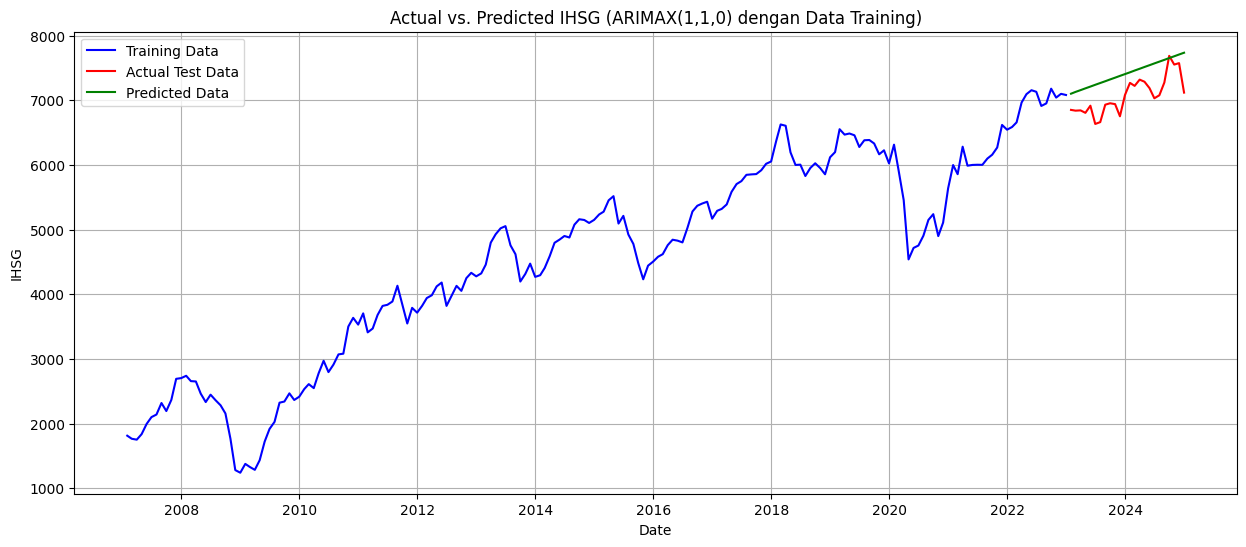

In [89]:
# === Plot data aktual vs. prediksi ===
plt.figure(figsize=(15, 6))

# Plot data training
plt.plot(train.index, y_train_open, label='Training Data', color='blue')

# Plot data testing aktual
plt.plot(test.index, y_test_open, label='Actual Test Data', color='red')

# Plot hasil prediksi ARIMAX (sudah transformasi balik)
plt.plot(y_test_open.index, predicted, label='Predicted Data', color='green')

plt.xlabel('Date')
plt.ylabel('IHSG')
plt.title('Actual vs. Predicted IHSG (ARIMAX(1,1,0) dengan Data Training)')
plt.legend()
plt.grid(True)
plt.show()

In [90]:
# === Evaluasi Model ===
# Invers transformasi (Jika perlu) atau gunakan nilai asli prediksi
mape_test = mean_absolute_percentage_error(y_test_open, predicted)
print("=== Evaluasi Model ARIMAX(0,1,1) pada Data Testing OPEN ===")
print(f"MAPE: {mape_test:.4f}")


=== Evaluasi Model ARIMAX(0,1,1) pada Data Testing OPEN ===
MAPE: 0.0496


# PERAMALAN 1 TAHUN KEDEPAN

## CLOSE

=== Hasil Peramalan IHSG 24 Bulan ke Depan (ARIMA(1,1,0)) ===
              Peramalan
2025-01-01  6840.153833
2025-02-01  6861.462865
2025-03-01  6887.356610
2025-04-01  6913.911866
2025-05-01  6940.562567
2025-06-01  6967.227040
2025-07-01  6993.893501
2025-08-01  7020.560248
2025-09-01  7047.227036
2025-10-01  7073.893831
2025-11-01  7100.560626
2025-12-01  7127.227421
2026-01-01  7153.894217
2026-02-01  7180.561012
2026-03-01  7207.227807
2026-04-01  7233.894603
2026-05-01  7260.561398
2026-06-01  7287.228193
2026-07-01  7313.894989
2026-08-01  7340.561784
2026-09-01  7367.228579
2026-10-01  7393.895375
2026-11-01  7420.562170
2026-12-01  7447.228966


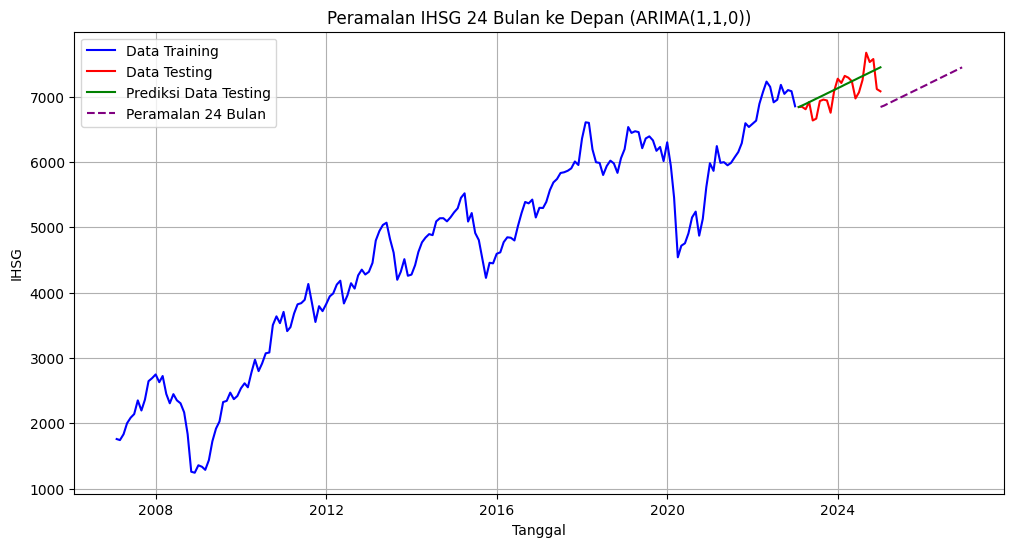

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Menentukan periode peramalan (24 bulan ke depan, mulai Januari 2025)
future_dates = pd.date_range(start='2025-01-01', periods=24, freq='MS')

# Melakukan peramalan menggunakan model ARIMA(1,1,0)
forecast = model_ar1.get_forecast(steps=24)
predicted_diff_future = forecast.predicted_mean

# Invers differencing untuk mendapatkan nilai IHSG
predicted_future = y_train.iloc[-1] + predicted_diff_future.cumsum()

# Membuat DataFrame hasil peramalan
hasil_peramalan = pd.DataFrame(index=future_dates, columns=['Peramalan'])
hasil_peramalan['Peramalan'] = predicted_future.values

# Menampilkan hasil peramalan
print("=== Hasil Peramalan IHSG 24 Bulan ke Depan (ARIMA(1,1,0)) ===")
print(hasil_peramalan)

# Plot data
plt.figure(figsize=(12, 6))

# Plot data training
plt.plot(y_train.index, y_train, label='Data Training', color='blue')

# Plot data testing aktual
plt.plot(y_test.index, y_test, label='Data Testing', color='red')

# Plot hasil prediksi ARIMA (sudah transformasi balik)
plt.plot(y_test.index, predicted, label='Prediksi Data Testing', color='green')

# Plot peramalan 24 bulan ke depan
plt.plot(hasil_peramalan.index, hasil_peramalan['Peramalan'], label='Peramalan 24 Bulan', color='purple', linestyle='--')

# Menambahkan label dan judul
plt.xlabel('Tanggal')
plt.ylabel('IHSG')
plt.title('Peramalan IHSG 24 Bulan ke Depan (ARIMA(1,1,0))')
plt.legend()
plt.grid(True)

# Menampilkan plot
plt.show()

##OPEN

=== Hasil Peramalan IHSG Open 24 Bulan ke Depan (MA(1)) ===
              Peramalan
2025-01-01  7101.126858
2025-02-01  7128.671586
2025-03-01  7156.216314
2025-04-01  7183.761041
2025-05-01  7211.305769
2025-06-01  7238.850497
2025-07-01  7266.395225
2025-08-01  7293.939952
2025-09-01  7321.484680
2025-10-01  7349.029408
2025-11-01  7376.574136
2025-12-01  7404.118863
2026-01-01  7431.663591
2026-02-01  7459.208319
2026-03-01  7486.753047
2026-04-01  7514.297774
2026-05-01  7541.842502
2026-06-01  7569.387230
2026-07-01  7596.931958
2026-08-01  7624.476686
2026-09-01  7652.021413
2026-10-01  7679.566141
2026-11-01  7707.110869
2026-12-01  7734.655597


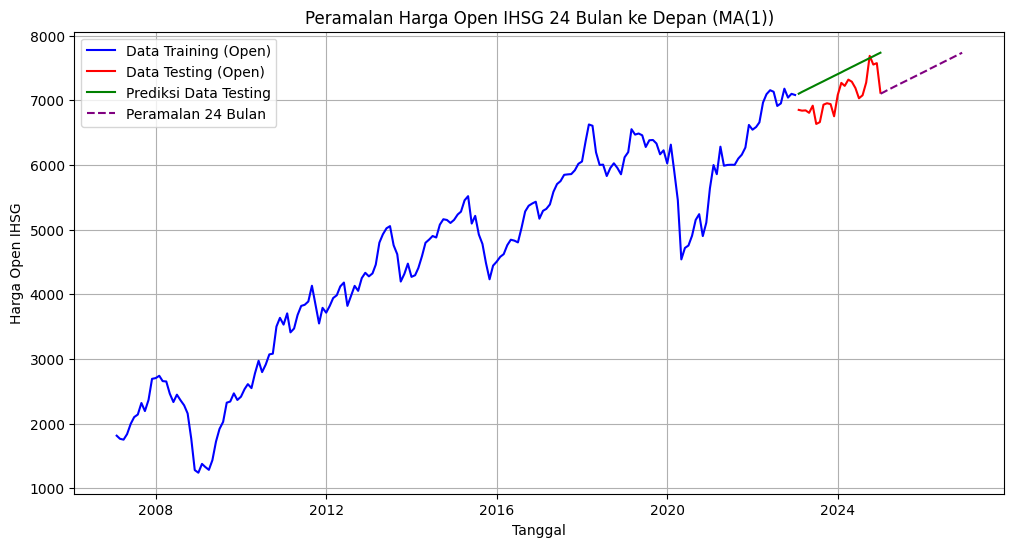

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Menentukan periode peramalan (24 bulan ke depan, mulai Januari 2025)
future_dates = pd.date_range(start='2025-01-01', periods=24, freq='MS')

# Melakukan peramalan menggunakan model MA(1) untuk data Open
forecast = model_ma1open.get_forecast(steps=24)
predicted_diff_future = forecast.predicted_mean

# Invers differencing untuk mendapatkan nilai prediksi aktual
predicted_future = y_train_open.iloc[-1] + predicted_diff_future.cumsum()

# Membuat DataFrame hasil peramalan
hasil_peramalan = pd.DataFrame(index=future_dates, columns=['Peramalan'])
hasil_peramalan['Peramalan'] = predicted_future.values

# Menampilkan hasil peramalan
print("=== Hasil Peramalan IHSG Open 24 Bulan ke Depan (MA(1)) ===")
print(hasil_peramalan)

# Plot data
plt.figure(figsize=(12, 6))

# Plot data training
plt.plot(y_train_open.index, y_train_open, label='Data Training (Open)', color='blue')

# Plot data testing aktual
plt.plot(y_test_open.index, y_test_open, label='Data Testing (Open)', color='red')

# Plot hasil prediksi (menggunakan nama 'predicted' seperti sebelumnya)
plt.plot(y_test_open.index, predicted, label='Prediksi Data Testing', color='green')

# Plot peramalan 24 bulan ke depan
plt.plot(hasil_peramalan.index, hasil_peramalan['Peramalan'], label='Peramalan 24 Bulan', color='purple', linestyle='--')

# Tambahkan label dan judul
plt.xlabel('Tanggal')
plt.ylabel('Harga Open IHSG')
plt.title('Peramalan Harga Open IHSG 24 Bulan ke Depan (MA(1))')
plt.legend()
plt.grid(True)

# Tampilkan plot
plt.show()